In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf

from prediction_ML_pipeline import train_and_evaluate_model
from order_imbalance import order_imbalance, combined_order_imbalance, diagnostic_plots, lm_results

In [2]:
MSFT_m = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_message_10.csv", header=None)
MSFT_ob = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)

In [3]:
AAPL_m2 = pd.read_csv("./data/AAPL/AAPL_2019-01-02_24900000_57900000_message_10.csv", header=None)
AAPL_m3 = pd.read_csv("./data/AAPL/AAPL_2019-01-03_24900000_57900000_message_10.csv", header=None)
AAPL_m4 = pd.read_csv("./data/AAPL/AAPL_2019-01-04_24900000_57900000_message_10.csv", header=None)

AAPL_ob2 = pd.read_csv("./data/AAPL/AAPL_2019-01-02_24900000_57900000_orderbook_10.csv", header=None)
AAPL_ob3 = pd.read_csv("./data/AAPL/AAPL_2019-01-03_24900000_57900000_orderbook_10.csv", header=None)
AAPL_ob4 = pd.read_csv("./data/AAPL/AAPL_2019-01-04_24900000_57900000_orderbook_10.csv", header=None)

AAPL_m = pd.concat([AAPL_m2, AAPL_m3, AAPL_m4])
AAPL_ob = pd.concat([AAPL_ob2, AAPL_ob3, AAPL_ob4])

In [4]:
df_m_labelled_lst = [MSFT_m]
df_ob_labelled_lst = [MSFT_ob]
tickers_train = ['MSFT']
df_m_predict_lst = [AAPL_m]
df_ob_predict_lst = [AAPL_ob]
tickers_pred = ['AAPL']

In [5]:
classifier = RandomForestClassifier()
param_grid = {
    'n_estimators': [50],
    # 'max_depth': [None, 10, 20, 30],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
}


results = train_and_evaluate_model(classifier, param_grid, df_ob_labelled_lst, 
                                   df_m_labelled_lst, tickers_train,
                                   df_ob_predict_lst, df_m_predict_lst, tickers_pred)
df_labelled_dict, df_predict_dict, features_dict, prediction_dict, best_classifier = results

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
Best parameters found:  {'n_estimators': 50}
Best accuracy found:  0.9105605737059073
Accuracy on the train data: 1.0
Accuracy on the test data: 0.9225251076040172


In [11]:
order_imbalance_AAPL = combined_order_imbalance(df_predict_dict['AAPL'][0], prediction_dict['pred'], delta='30S')

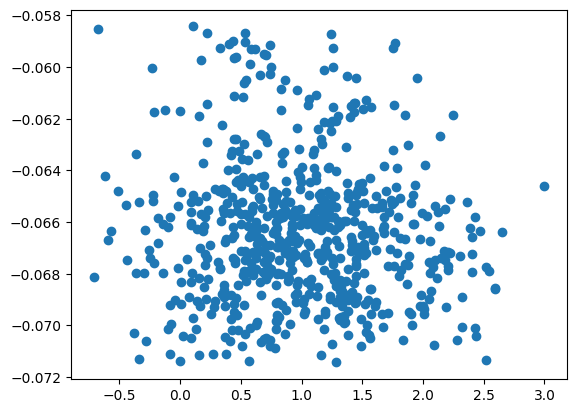

In [12]:
plt.scatter(order_imbalance_AAPL['order_imbalance_hid'][:-1], order_imbalance_AAPL['log_ret'][1:])

In [13]:
lm = smf.ols(formula="""fut_log_ret ~ order_imbalance_vis + order_imbalance_hid""", data=order_imbalance_AAPL).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fut_log_ret   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.216
Date:                Thu, 18 Jul 2024   Prob (F-statistic):              0.110
Time:                        22:30:42   Log-Likelihood:                 2939.1
No. Observations:                 654   AIC:                            -5872.
Df Residuals:                     651   BIC:                            -5859.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0660      0.000   -344.313      0.000      -0.066      -0.066
order_imbalance_vis     0.0002      0.000      0.393      0.695      -0.001       0.001
order_imbalance_hid    -0.0003      0.000     -2.105      0.036      -0.001   -2.33e-05
==============================================================================
Omnibus:                       41.053   Durbin-Watson:                   0.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.176
Skew:                           0.647   Prob(JB):                     5.70e-11
Kurtosis:                       3.236   Cond. No.                         5.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
df_results = lm_results(df_predict_dict['AAPL'][0], prediction_dict['pred'], ['15S', '30S', '1min', '5min', '10min'],
                        order_type='combined', predictive=True)
df_results

,timeframe,params_vis,tvalues_vis,params_hid,tvalues_hid
0,15S,-0.000184,-0.659067,-0.000196,-1.908663
1,30S,0.000163,0.392757,-0.000347,-2.104711
2,1min,-0.000182,-0.269830,-0.000428,-1.481812
3,5min,0.001434,0.580283,-0.001553,-1.290726
4,10min,-0.004424,-1.264222,-0.005301,-2.471483
